# Compondo com inteligência
Mateus Augusto Viotto - PC3008967

## Bibliotecas

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, transform, util
import skimage

import tensorflow.compat.v1 as tf
import cv2
import itertools

#from google.colab.patches import cv2_imshow

## Altere para os diretórios correspondentes

In [2]:
diretorio_vocabulario = 'vocabulary_semantic.txt' #ALTERE PARA O DIRETÓRIO DO VOCABULARIO DISPONÍVEL EM https://github.com/OMR-Research/tf-end-to-end/blob/master/Data/vocabulary_semantic.txt
diretorio_modelo = 'model\semantic_model.meta' #ALTERE PARA O DIRETÓRIO DO MODELO DISPONÍVEL EM https://grfia.dlsi.ua.es/primus/models/PrIMuS/Semantic-Model.zip

# Carrega dados do arquivo 'clef.xlsx' para o DataFrame 'clef'
clef = pd.read_excel('clef.xlsx')

# Carrega dados do arquivo 'gracenote.xlsx' para o DataFrame 'gracenote'
gracenote = pd.read_excel('gracenote.xlsx')
gracenote['oitava'] = gracenote['oitava'].astype(str).str.replace('.0', '')

# Carrega dados do arquivo 'keySignature.xlsx' para o DataFrame 'keySignature'
keySignature = pd.read_excel('keySignature.xlsx')

# Carrega dados do arquivo 'notes.xlsx' para o DataFrame 'notes'
notes = pd.read_excel('notes.xlsx')
notes['oitava'] = notes['oitava'].astype(str).str.replace('.0', '')

# Carrega dados do arquivo 'options.xlsx' para o DataFrame 'options'
options = pd.read_excel('options.xlsx')

# Carrega dados do arquivo 'rest.xlsx' para o DataFrame 'rest'
rest = pd.read_excel('rest.xlsx')

# Carrega dados do arquivo 'timeSignature.xlsx' para o DataFrame 'timeSignature'
timeSignature = pd.read_excel('timeSignature.xlsx')

C:\Users\mateu\AppData\Local\Temp\ipykernel_12560\1204828071.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  gracenote['oitava'] = gracenote['oitava'].astype(str).str.replace('.0', '')
C:\Users\mateu\AppData\Local\Temp\ipykernel_12560\1204828071.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  notes['oitava'] = notes['oitava'].astype(str).str.replace('.0', '')


## Funções ler e salvar

Salva a imagem em formato *jpg* no diretório atual.

In [3]:
def salvar_imagem(imagem, nome):
  io.imsave(nome+'.jpg', imagem)

Lê o vocabulário armazenado no arquito *txt* e armazena em um dicionário.

In [58]:
def ler_vocabulario(diretorio):
    # Abra o arquivo para leitura
    with open(diretorio, 'r') as arquivo:
      # Leia as linhas e armazene em uma lista
      linhas = arquivo.readlines()

    # Cada elemento da lista representa uma linha do arquivo

    dicionario = dict()
    i = 0
    for palavra in linhas:

        dicionario[i] = palavra.replace("\n", "")
        i += 1
    return dicionario


In [61]:
def mostrar_imagem(img):
    # Exiba a imagem usando matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')  # Desliga os eixos
        plt.show()

## Funções Pré-processamento

### Converte uma imagem colorida para escala de cinza.

In [40]:
def deixar_cinza(imagem):
    #print('Convertendo para escala de cinza. . .')
    return cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

### Binariza a imagem utilizando o método *threshold_sauvola*.

In [41]:
def binarizar(image):
    from skimage.filters import threshold_sauvola
    #print('Binarizando imagem. . .')
    # tamanho da janela de cálculo local do limiar
    window_size = 101

    # fator de sensibilidade
    k = 0.2

    # Calcule o limiar de Sauvola
    threshold = threshold_sauvola(image, window_size=window_size, k=k)

    # Aplique o limiar à imagem para binarizá-la
    binary_image = image > threshold

    return binary_image


### Plota um gráfico horizontal da projeção horizontal para visualização da linha de pauta.

In [33]:
def linhadepauta(projection_data):
    import matplotlib.pyplot as plt

    # Combina os arrays em um único array
    combined_data = [item for sublist in projection_data for item in sublist]

    # Define o intervalo de exibição no eixo X
    x_values = range(1, len(combined_data) + 1)  # De 1 a N

    # Define o passo para os rótulos do eixo X (exibe a cada 300 valores)
    x_ticks = list(range(1, len(combined_data) + 1, 50))  # Exibe a cada 300 valores

    # Cria um gráfico de barras horizontais
    plt.barh(x_values, combined_data, color='black')

    # Inverte o eixo Y para que os valores mais altos fiquem no topo
    plt.gca().invert_yaxis()

    # Configura os rótulos do eixo X
    plt.yticks(x_ticks, x_ticks)

    plt.show()

### Calcula a projeção horizontal.

In [43]:
def calcular_projecao(img_data, col_row=1):
    #print('Calculando projeção horizontal. . .')
    # Cria uma máscara onde os valores 0 na imagem original são mapeados para 1, e outros para 0
    mask = np.uint8(np.where(img_data == 0, 1, 0))

    # Calcula a projeção somando os valores na máscara ao longo de uma coluna (col_row=1) ou linha (col_row=0)
    # REDUCE_SUM realiza a soma
    # dtype=cv2.CV_32SC1 define o tipo de dados do resultado como 32 bits com sinal
    count = cv2.reduce(mask, col_row, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

    return count

### Rotaciona a imagem.

In [9]:
def girar_imagem(img_data, angle):

    # Rotacionar a imagem
    new_image = util.img_as_ubyte(transform.rotate(img_data, angle, mode='wrap'))

    return new_image

### Endireita a imagem, rotacionando-a caso esteja inclinada.

In [45]:
def alinhar_linhas(img_data):
    #print('Alinhando a imagem. . .')
    best_image = None  # Variável para armazenar a melhor imagem alinhada
    maximum = 0  # Variável para armazenar o valor máximo de projeção

    # Loop através de diferentes ângulos de rotação
    for i in range(-40, 40):
        angle = 0.25 * i  # Calcula o ângulo de rotação correspondente

        # Gira a imagem original pelo ângulo calculado
        new_image = girar_imagem(img_data, angle)

        # Binariza a nova imagem (converte para imagem binária)
        binary_image = binarizar(new_image)

        # Calcula a projeção horizontal da imagem binária
        horizontal_projection = calcular_projecao(binary_image)

        # Encontra o valor máximo na projeção horizontal
        max_projection = max(horizontal_projection)

        # Verifica se o valor máximo encontrado é maior que o máximo atual
        if max_projection > maximum:
            best_image = new_image  # Se for maior, atualiza a melhor imagem
            maximum = max_projection  # Atualiza o valor máximo

    return best_image  # Retorna a melhor imagem alinhada

In [11]:
def get_reference_lenghts(img_data):
    # Dicionários para armazenar o número de corridas de pixels pretos e brancos
    black_runs = {}
    white_runs = {}

    # Itera sobre todas as colunas da imagem
    for i in range(img_data.shape[1]):
        col = img_data[:, i]
        
        # Agrupa os valores consecutivos na coluna
        for k, g in itertools.groupby(col):
            length = len(list(g))
            
            # Atualiza os dicionários com base na cor do pixel
            if k == 0:
                black_runs[length] = black_runs.get(length, 0) + 1
            else:
                white_runs[length] = white_runs.get(length, 0) + 1

    # Determina a espessura da linha e o espaço entre linhas com base nas corridas
    line_thickness = max(black_runs, key=black_runs.get)
    staff_space = max(white_runs, key=white_runs.get)

    return line_thickness, staff_space

### Identificar pautas

In [62]:
def identificarpautas(img):
 
    
    print("Identificando as pautas. . .")
    image = img.copy()

    # Obtém as dimensões da imagem
    altura, largura = image.shape

    # Lista para armazenar as pautas identificadas
    pautas = []

    # Converte a imagem em escala de cinza
    #cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplica o detector de bordas Canny
    canny = cv2.Canny(img, 80, 200)

    # Detecta linhas na imagem usando a transformada de Hough
    linhas = cv2.HoughLinesP(canny, 1, np.pi / 180, 70, minLineLength=30, maxLineGap=5)

    # Desenha as linhas detectadas na imagem original
    for linha in linhas:
        x1, y1, x2, y2 = linha[0]
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 0), 10)

    # Converte a imagem novamente em escala de cinza
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplica um desfoque gaussiano
    blur = cv2.GaussianBlur(img, (7, 7), 0)

    # Aplica uma limiarização binária inversa
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Define um kernel para a operação de dilatação
    kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))

    # Realiza a dilatação para unir áreas próximas
    dilate = cv2.dilate(thresh, kernal, iterations=0)

    # Encontra os contornos na imagem dilatada
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #cv2_imshow(img)
    # Itera sobre os contornos encontrados
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)

        # Verifica se o contorno representa uma pauta musical
        if h > 20 and w > largura // 2 and h < altura - 20:
            roi = image[y:y + h, x:x + w]
            pautas.append(roi)

    # Inverte a ordem das pautas para a exibição correta
    pautas.reverse()

    # Exibe cada pauta encontrada
    for p in pautas:
        print('\n')
        mostrar_imagem(p)
    return pautas

## Funções Identificar Símbolos

### Normaliza a imagem

In [36]:
def normalize(image):
    print('Normalizando a imagem. . .')
    return (255. - image)/255.

### Redimenciona a imagem

In [37]:
def resize(image, height):
    print('Redimencionando a imagem. . .')
    # Calcula a largura proporcional à altura fornecida
    width = int(float(height * image.shape[1]) / image.shape[0])

    # Redimensiona a imagem para a nova largura e altura
    sample_img = cv2.resize(image, (width, height))

    return sample_img

In [15]:
def sparse_tensor_to_strs(sparse_tensor):
    # Extrai os componentes do tensor esparsa
    indices = sparse_tensor[0][0]
    values = sparse_tensor[0][1]
    dense_shape = sparse_tensor[0][2]

    # Inicializa uma lista de listas para armazenar as strings
    strs = [[] for i in range(dense_shape[0])]

    # Inicializa uma lista temporária para armazenar cada string
    string = []
    ptr = 0
    b = 0

    # Itera sobre os índices para construir as strings
    for idx in range(len(indices)):
        # Verifica se mudou de linha
        if indices[idx][0] != b:
            strs[b] = string
            string = []
            b = indices[idx][0]

        # Adiciona o valor atual à string temporária
        string.append(values[ptr])

        ptr = ptr + 1

    # Armazena a última string na linha final
    strs[b] = string

    return strs


### Identifica os símbolos

In [ ]:
def identificar_simbolos(imagem, vocabulario, diretorio):
    print('Identificando os símbolos')
    # Desabilita a execução ansiosa
    tf.compat.v1.disable_eager_execution()
    # Cria um novo grafo padrão do TensorFlow
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    # Cria um objeto Saver para importar o modelo
    saver = tf.train.import_meta_graph(diretorio)

    # Restaura os parâmetros do modelo a partir do arquivo
    saver.restore(sess, diretorio[:-5])  # Remove a extensão ".meta" do diretório
    graph = tf.get_default_graph()
    
    # Obter tensores necessários do grafo
    input = graph.get_tensor_by_name("model_input:0")  # Dados de entrada
    seq_len = graph.get_tensor_by_name("seq_lengths:0")  # Comprimento da sequência
    rnn_keep_prob = graph.get_tensor_by_name("keep_prob:0")  # Probabilidade de manter unidades
    height_tensor = graph.get_tensor_by_name("input_height:0")  # Altura da entrada
    width_reduction_tensor = graph.get_tensor_by_name("width_reduction:0")  # Redução de largura
    logits = tf.get_collection("logits")[0]  # Saídas da rede neural (normalmente, saídas da camada softmax)

    # Obter constantes do modelo
    WIDTH_REDUCTION, HEIGHT = sess.run([width_reduction_tensor, height_tensor])

    decoded, _ = tf.nn.ctc_greedy_decoder(logits, seq_len)  # Decodificação CTC

    # Pré-processamento da imagem de entrada
    image = imagem
    image = resize(image, HEIGHT)  # Redimensiona a imagem
    image = normalize(image)  # Normaliza a imagem
    image = np.asarray(image).reshape(1, image.shape[0], image.shape[1], 1)  # Formata a imagem para o modelo

    seq_lengths = [image.shape[2] / WIDTH_REDUCTION]  # Comprimento da sequência

    # Executa a rede neural com a imagem de entrada
    prediction = sess.run(decoded, feed_dict={
        input: image,
        seq_len: seq_lengths,
        rnn_keep_prob: 1.0,
    })

    # Converte a saída da decodificação em texto usando o vocabulário
    str_predictions = sparse_tensor_to_strs(prediction)

    # Retorna a lista de símbolos reconhecidos
    return [vocabulario[w] for w in str_predictions[0]]

## Funções Correção

### Pré-correção

In [17]:
def precorrecao(pauta, primeira):
    pauta_corrigida = []
    print('Pré-corrigindo os resultados. . .\n')

    #Verifica se tem uma clave no começo da pauta
    if 'clef' not in pauta[0]:
        pauta.insert(0, 'clef-G2')

    #Verifica se tem um tempo no começo da pauta
    if 'timeSignature' not in pauta[1] and 'timeSignature' not in pauta[2] and primeira == True:
        if 'keySignature' in pauta[1]:
            pauta.insert(2, 'timeSignature-3/4')
        else:
            pauta.insert(1, 'timeSignature-3/4')

    #Verifica se existem dois barline's seguidos
    i = 0
    while i < len(pauta) - 1:
        if pauta[i] == 'barline' and pauta[i + 1] == 'barline':
            # Se dois itens 'barline' consecutivos forem encontrados, remova um deles
            pauta.pop(i + 1)
        else:
            i += 1

    #Separa os compassos
    compassos = []
    compasso_atual = []

    for item in pauta:
        compasso_atual.append(item)
        if item == 'barline':
            compassos.append(compasso_atual)
            compasso_atual = []

    if compasso_atual:
        compassos.append(compasso_atual)

    #Verifica cada compasso
    for comp in compassos:
        # Encontra o índice da primeira ocorrência de uma palavra contendo "clef"
        index_to_keep = -1

        for i, item in enumerate(comp):
            if 'clef' in item:
                index_to_keep = i
                break

        # Remove todas as outras ocorrências de palavras contendo "clef"
        comp = [item for i, item in enumerate(comp) if i == index_to_keep or 'clef' not in item]


        # Encontra o índice da primeira ocorrência de uma palavra contendo "timeSignature"
        index_to_keep = -1

        for i, item in enumerate(comp):
            if 'timeSignature' in item:
                index_to_keep = i
                break

        # Remove todas as outras ocorrências de palavras contendo "timeSignature"
        comp = [item for i, item in enumerate(comp) if i == index_to_keep or 'timeSignature' not in item]

        # Encontra o índice da primeira ocorrência de uma palavra contendo "keySignature"
        index_to_keep = -1

        for i, item in enumerate(comp):
            if 'keySignature' in item:
                index_to_keep = i
                break

        # Remove todas as outras ocorrências de palavras contendo "keySignature"
        comp = [item for i, item in enumerate(comp) if i == index_to_keep or 'keySignature' not in item]

        for c in comp:
            pauta_corrigida.append(c)

    return pauta_corrigida

### Correção do usuário

In [ ]:
def correcaoUsuario(pauta):
    print('Iniciando a correção do usuário. . .\n')
    
    while True:
        print(pauta)

        # Pergunta ao usuário se a classificação está correta
        resposta = int(input('\nA classificação está correta? (1- Sim | 2- Não)'))

        if resposta == 1:
            return pauta

        elif resposta == 2:
            i = 1
            print('\nQual a posição do elemento que deseja alterar?')

            # Mostra os elementos da pauta e solicita a posição do elemento a ser alterado
            for elem in pauta:
                print(str(i) + '-' + elem, end=' ')
                i = i + 1
            posicao = int(input())

            # Pergunta ao usuário qual tipo de alteração deseja realizar
            alteracao = int(input('\nQual alteração deseja realizar? (1- Adicionar | 2- Editar | 3- Deletar)'))

            # Executa a ação correspondente com base na escolha do usuário
            if alteracao == 1:
                pauta = adicionar(pauta, posicao - 1)
            elif alteracao == 2:
                pauta = editar(pauta, posicao - 1)
            elif alteracao == 3:
                pauta = deletar(pauta, posicao - 1)
            else:
                # Mensagem de erro se a opção escolhida não for válida
                print('\nUtilize 1 para Adicionar, 2 para Editar ou 3 para Deletar.')
                correcaoUsuario(pauta)

        else:
            # Mensagem de erro se a opção escolhida não for válida
            print('\nUtilize 1 para Sim ou 2 para Não.')


### Deletar

In [ ]:
def deletar(pauta, posicao):
    del pauta[posicao] #Deleta o elemento da pauta
    return pauta

### Adicionar

In [ ]:
def adicionar(pauta, posicao):
    # Solicita a posição de adição do novo elemento
    pos = int(input('\nOnde deseja adicionar o novo elemento? 1- A frente | 2- Atrás'))
    if pos == 1:
        posicao = posicao + 1
    elif pos == 2: 
        posicao = posicao - 1

    # Solicita o tipo de elemento a ser adicionado
    print('\nQual elemento deseja adicionar? Utilize o número referente ao elemento.')
    display(options)
    elemento = int(input())

    if elemento == 0:
        # Adiciona uma nota musical à pauta
        nota = notes['nota'].dropna()
        oitava = notes['oitava'].dropna()
        oitava = oitava[:6]
        ritmo = notes['ritmo'].dropna()

        print('\nQual nota deseja adicionar? Utilize o número referente a nota.')
        display(nota)
        pos_nota = int(input())

        print('\nQual a oitava da nota? Utilize o número referente a oitava.')
        display(oitava)
        pos_oitava = int(input())

        print('\nQual o ritmo da nota? Utilize o número referente ao ritmo.')
        display(ritmo)
        pos_ritmo = int(input())

        novo_elemento = 'note-' + nota.iloc[pos_nota] + str(oitava.iloc[pos_oitava]) + '_' + ritmo.iloc[pos_ritmo]

    elif elemento == 1:
        # Adiciona um descanso à pauta
        print('\nQual rest deseja adicionar? Utilize o número referente a rest.')
        display(rest)
        elem = int(input())
        novo_elemento = 'rest-' + rest.iloc[elem]['rest']


    pauta.insert(posicao, novo_elemento)
    return pauta


### Editar

In [ ]:
def editar(pauta, posicao):
    # Solicita o tipo de elemento a ser usado para a substituição
    print('\nQual elemento deseja substituir o ' + pauta[posicao] + '? Utilize o número referente ao elemento.')
    display(options)
    elemento = int(input())

    if elemento == 0:
        # Substitui o elemento atual por uma nova nota musical
        nota = notes['nota'].dropna()
        oitava = notes['oitava'].dropna()
        oitava = oitava[:6]
        ritmo = notes['ritmo'].dropna()

        print('\nQual nota deseja adicionar? Utilize o número referente a nota.')
        display(nota)
        pos_nota = int(input())

        print('\nQual a oitava da nota? Utilize o número referente a oitava.')
        display(oitava)
        pos_oitava = int(input())

        print('\nQual o ritmo da nota? Utilize o número referente ao ritmo.')
        display(ritmo)
        pos_ritmo = int(input())

        novo_elemento = 'note-' + nota.iloc[pos_nota] + str(oitava.iloc[pos_oitava]) + '_' + ritmo.iloc[pos_ritmo]

    elif elemento == 1:
        # Substitui o elemento atual por um novo descanso
        print('\nQual rest deseja adicionar? Utilize o número referente a rest.')
        display(rest)
        elem = int(input())
        novo_elemento = 'rest-' + rest.iloc[elem]['rest']

    # ... (continua para outros tipos de elementos)

    elif elemento == 7:
        # Substitui o elemento atual por uma nova keySignature
        print('\nQual keySignature deseja adicionar? Utilize o número referente a keySignature.')
        display(keySignature)
        elem = int(input())
        novo_elemento = 'keySignature-' + keySignature.iloc[elem]['keySignature']

    # Atualiza a pauta na posição especificada
    pauta[posicao] = novo_elemento
        
    return pauta


## Pré-processamento

### Imagem alinhada e binarizada

Identificando as pautas. . .




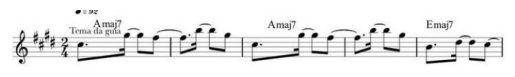

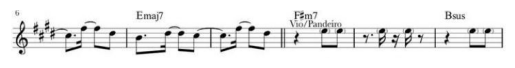

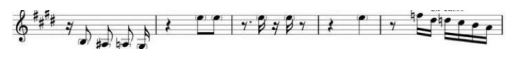

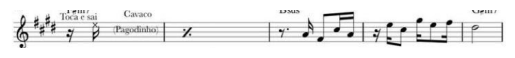

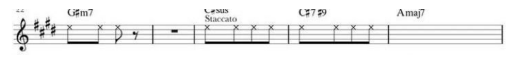

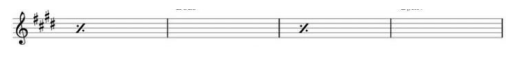


=================== Analisando pauta 1 ===================

Alinhando a imagem. . .


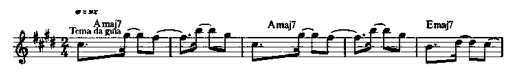

Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model
Redimencionando a imagem. . .
Normalizando a imagem. . .
Pré-corrigindo os resultados. . .

Iniciando a correção do usuário. . .

['clef-G2', 'keySignature-EM', 'timeSignature-2/4', 'note-D6_eighth.', 'note-F#5_eighth.', 'note-E5_sixteenth', 'note-E5_eighth', 'note-F#5_eighth', 'barline', 'note-F#5_eighth.', 'note-A5_sixteenth', 'note-A5_eighth', 'note-G#5_eighth', 'barline', 'note-C#5_eighth.', 'gracenote-G#5_eighth', 'note-E5_sixteenth', 'note-E5_eighth', 'note-F#5_eighth', 'barline', 'note-D5_eighth.', 'note-A5_sixteenth', 'note-G#5_eighth', 'note-G#5_eighth', 'barline', 'note-B4_eighth.', 'note-B4_sixteenth', 'note-D5_eighth', 'note-C#5_eighth', 'barline']


KeyboardInterrupt: Interrupted by user

In [65]:
diretorio_imagem = 'partitura.jpg'

imagem = cv2.imread(diretorio_imagem)
imagem_cinza = deixar_cinza(imagem)
pautas = identificarpautas(imagem_cinza)
vocabulario = ler_vocabulario(diretorio_vocabulario)
pautafinal = []
i = 1
primeira = True

for pauta in pautas:
    print('\n=================== Analisando pauta '+str(i) +' ===================')
    i = i + 1
    imagem_binarizada = binarizar(pauta)
    
    #salvar_imagem(imagem_binarizada, 'images\\binarized\\'+diretorio_imagem[:-4]+'-binarizada')
    print('\nAlinhando a imagem. . .')
    imagem_alinhada = alinhar_linhas(imagem_binarizada)
    #salvar_imagem(imagem_alinhada, 'images\\aligned\\'+diretorio_imagem[:-4]+'-alinhada')
    mostrar_imagem(imagem_alinhada)
    #projecao = calcular_projecao(imagem_alinhada)
    #linhadepauta(projecao)
    
    # Use a função 'img_as_ubyte' para converter a imagem para ubytes
    img_data = skimage.img_as_ubyte(imagem_alinhada)
    
    line_thickness, staff_space = get_reference_lenghts(img_data)
    symbols = identificar_simbolos(img_data, vocabulario, diretorio_modelo)
    #print('\n', symbols)
    
    pautaprecorrigida = precorrecao(symbols, primeira)
    primeira = False
    pautacorrigida = correcaoUsuario(pautaprecorrigida)
    pautafinal.append(pautacorrigida)

# Gera uma partitura

# Gera um MIDI

In [128]:
# Adiciona notas e elementos ao compasso
notas_e_elementos = [
    'note-Bb5_quarter', 'note-Eb5_eighth', 'note-Bb5_eighth', 'note-Eb6_eighth',
    'note-Bb5_eighth', 'barline', 'note-Ab5_eighth', 'note-Ab5_eighth',
    'rest-sixteenth', 'note-Ab5_sixteenth', 'note-G5_sixteenth',
    'note-Ab5_sixteenth', 'note-Bb5_sixteenth', 'note-Ab5_sixteenth',
    'note-G5_sixteenth', 'note-Ab5_sixteenth', 'barline'
]

for elemento in notas_e_elementos:
    if 'note' in elemento:
        # Separa o tipo de nota, a oitava e o acidental
        tipo_nota, oitava_duracao = elemento.split('-')[1].split('_')
        print(tipo_nota)
        altura = tipo_nota[:-1]  # Remove o acidental da altura
        acidental = tipo_nota[-1] if tipo_nota[-1] in ['b', '#'] else None  # Verifica se há um acidental
        print(oitava_duracao.split('_')[0])

        # Adiciona a nota ao compasso
        nota = note.Note(altura)
        if acidental:
            nota.accidental = pitch.Accidental(acidental)
        compasso.append(nota)

        # Adiciona a duração da nota
        duracao_em_quarters = duracao
        nota.duration.quarterLength = duracao_em_quarters
    elif 'rest' in elemento:
        # Adiciona uma pausa ao compasso
        duracao = elemento.split('-')[1]
        duracao_em_quarters = duracao
        pausa = note.Rest(quarterLength=duracao_em_quarters)
        compasso.append(pausa)
    elif 'barline' in elemento:
        # Adiciona uma barra de compasso
        compasso.append(bar.Barline())


Bb5
quarter


TypeError: Cannot convert num: quarter

In [129]:
from music21 import stream, note, meter

# Cria um objeto Stream para representar a partitura
partitura = stream.Score()

# Adiciona um compasso à partitura
compasso = stream.Part()
partitura.append(compasso)

# Adiciona notas ao compasso
notas = ['Bb4', 'D#4', 'E#4', 'F#4', 'G#4', 'A#4', 'B#4', 'C#4']
for nota in notas:
    nota_obj = note.Note(nota, quarterLength=1)
    compasso.append(nota_obj)

# Define o metro (4/4 neste exemplo)
compasso.append(meter.TimeSignature('4/4'))

# Salva a partitura em um arquivo em formato MIDI
partitura.write('midi', 'exemplo1.mid')


'exemplo1.mid'